In [123]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error
import seaborn as sns

In [ ]:
#a lot of things were done in a hurry and I wasnn't quite able to explain everything too well, but this just one of my testnotebooks so it might seem out of place

In [ ]:
#i used an xgbregressor to deal with this problem. another aproach i wanted to try was using the arima/sarimax but unfortunately did not get the time.

In [124]:
pd.set_option('display.max_rows', 10)

In [125]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample.csv')

In [126]:
train.head(60)

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81
...,...,...,...
55,2018-08-21,20,8
56,2018-08-21,22,80
57,2018-08-22,0,41
58,2018-08-22,6,82


In [127]:
train.loc[[4]]['date']

4    2018-08-18
Name: date, dtype: object

In [128]:
train.loc[[4]]['hour'] = 12

In [129]:
#TRY CREATING NEW DF FOR ALL DATES BETWEEN RANGE AND ADD ALL HOURS. THEN ADD PREV DF TO THIS DF AND GET RID OF DUPLICATES. ORDER BY DATE, HOUR.

In [130]:
#training data starts from 18th aug 2018 and ends at 28th feb 2021

start_date = datetime.date(2018, 8, 18)
end_date = datetime.date(2021, 2, 28)
delta = datetime.timedelta(days=1)
list1=[]
while start_date <= end_date:
    for i in range(24):
        list1.append(start_date.strftime("%Y-%m-%d"))
    start_date += delta

In [131]:
list2 = []
for i in range(int(len(list1)/24)):
    for j in range(24):
        list2.append(j)

In [132]:
list3 = [0]*len(list2)

In [133]:
new_df2 = pd.DataFrame(list(zip(list1, list2, list3)),
               columns =['date', 'hour','demand'])

In [134]:
new_df2

,date,hour,demand
0,2018-08-18,0,0
1,2018-08-18,1,0
2,2018-08-18,2,0
3,2018-08-18,3,0
4,2018-08-18,4,0
...,...,...,...
22219,2021-02-28,19,0
22220,2021-02-28,20,0
22221,2021-02-28,21,0
22222,2021-02-28,22,0


In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [136]:
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22224 entries, 0 to 22223
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    22224 non-null  object
 1   hour    22224 non-null  int64 
 2   demand  22224 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 521.0+ KB


In [137]:
new_df3 = pd.concat([new_df2, train])

In [138]:
new_df3

,date,hour,demand
0,2018-08-18,0,0
1,2018-08-18,1,0
2,2018-08-18,2,0
3,2018-08-18,3,0
4,2018-08-18,4,0
...,...,...,...
18242,2021-02-28,19,95
18243,2021-02-28,20,88
18244,2021-02-28,21,39
18245,2021-02-28,22,104


In [139]:
new_df3.drop_duplicates(subset=['date', 'hour'], keep='last',inplace=True)
new_df3.reset_index(drop = True)

,date,hour,demand
0,2018-08-18,0,0
1,2018-08-18,1,0
2,2018-08-18,2,0
3,2018-08-18,3,0
4,2018-08-18,4,0
...,...,...,...
22219,2021-02-28,19,95
22220,2021-02-28,20,88
22221,2021-02-28,21,39
22222,2021-02-28,22,104


In [140]:
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22224 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    22224 non-null  object
 1   hour    22224 non-null  int64 
 2   demand  22224 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 694.5+ KB


In [141]:
new_df3.demand.sum()

1350122

In [142]:
train.demand.sum()

1350122

In [143]:
len(new_df3)

22224

In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [145]:
new_df3['timestamp'] = new_df3['date'] + " " +new_df3['hour'].astype('str') + ":00:00"

In [146]:
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22224 entries, 0 to 18246
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       22224 non-null  object
 1   hour       22224 non-null  int64 
 2   demand     22224 non-null  int64 
 3   timestamp  22224 non-null  object
dtypes: int64(2), object(2)
memory usage: 868.1+ KB


In [147]:
new_df3['timestamp'] = pd.to_datetime(new_df3['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [148]:
new_df3.timestamp.min()

Timestamp('2018-08-18 00:00:00')

In [149]:
new_df3.timestamp.max()

Timestamp('2021-02-28 23:00:00')

In [150]:
new_df3 = new_df3.sort_values(["timestamp"], ascending=True)

In [151]:
new_df3 = new_df3.drop(['date','hour'], axis=1)

In [152]:
new_df3.head(40)

,demand,timestamp
0,0,2018-08-18 00:00:00
1,0,2018-08-18 01:00:00
2,0,2018-08-18 02:00:00
3,0,2018-08-18 03:00:00
4,0,2018-08-18 04:00:00
...,...,...
17,89,2018-08-19 11:00:00
18,114,2018-08-19 12:00:00
19,68,2018-08-19 13:00:00
20,65,2018-08-19 14:00:00


In [153]:
new_df3.set_index('timestamp',inplace = True)

In [154]:
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22224 entries, 2018-08-18 00:00:00 to 2021-02-28 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   demand  22224 non-null  int64
dtypes: int64(1)
memory usage: 347.2 KB


In [155]:
new_df3.head()

,demand
timestamp,
2018-08-18 00:00:00,0
2018-08-18 01:00:00,0
2018-08-18 02:00:00,0
2018-08-18 03:00:00,0
2018-08-18 04:00:00,0


In [ ]:
#to fill in missing values from 27th nov 2018 to 26th dec 2018

In [156]:
calc_demand = 0.5* (new_df3.loc['2018-11-27':'2018-12-26','demand'].values + new_df3.loc['2019-11-27':'2019-12-26','demand'].values)

new_df3.loc['2020-11-27':'2020-12-26','demand']=calc_demand

In [157]:
viz = new_df3

In [167]:
viz['timestamp'] = viz.index

In [168]:
viz['month'] = viz['timestamp'].dt.to_period('M')

In [169]:
df_by_month = viz.groupby(['month']).sum().reset_index()
df_by_month.info()
df_by_month['month'] = df_by_month['month'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   month   31 non-null     period[M]
 1   demand  31 non-null     float64  
dtypes: float64(1), period[M](1)
memory usage: 624.0 bytes


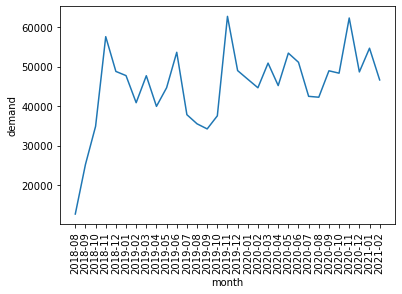

In [170]:
sns.lineplot(x = df_by_month.month, y = df_by_month.demand) 
plt.xticks(rotation=90)
  
# Show the plot
plt.show()

In [171]:
from statsmodels.tsa.stattools import adfuller

In [172]:
result = adfuller(viz.demand)

In [173]:
result[1]

3.3372426546529596e-20

In [174]:
xgbdf = viz
xgbdf['hour'] = viz['timestamp'].dt.hour
xgbdf['dayofweek'] = viz['timestamp'].dt.dayofweek
xgbdf['quarter'] = viz['timestamp'].dt.quarter
xgbdf['month'] = viz['timestamp'].dt.month
xgbdf['year'] = viz['timestamp'].dt.year
xgbdf['dayofyear'] = viz['timestamp'].dt.dayofyear
xgbdf['sin_day'] = np.sin(xgbdf['dayofyear'])
xgbdf['cos_day'] = np.cos(xgbdf['dayofyear'])
xgbdf['dayofmonth'] = viz['timestamp'].dt.day
xgbdf['weekofyear'] = viz['timestamp'].dt.weekofyear

<ipython-input-174-7275fc0cb488>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  xgbdf['weekofyear'] = viz['timestamp'].dt.weekofyear


In [175]:
xgbdf = xgbdf.drop(['timestamp'], axis=1)

In [176]:
xgbdf = xgbdf.drop(['sin_day','cos_day','dayofyear','weekofyear','quarter'], axis=1)

In [177]:
xgby = xgbdf['demand']

In [178]:
xgbdf = xgbdf.drop(['demand'], axis=1)

In [179]:
xgbdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22224 entries, 2018-08-18 00:00:00 to 2021-02-28 23:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   month       22224 non-null  int64
 1   hour        22224 non-null  int64
 2   dayofweek   22224 non-null  int64
 3   year        22224 non-null  int64
 4   dayofmonth  22224 non-null  int64
dtypes: int64(5)
memory usage: 1.5 MB


In [180]:
x_train = xgbdf[:15000]
x_test = xgbdf[15000:]
y_train = xgby[:15000]
y_test = xgby[15000:]

In [181]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(x_train, y_train,verbose=True)
ypred = reg.predict(x_test)

In [182]:
rmse = np.sqrt(mse(y_test, ypred))
print("RMSE : % f" %(rmse))

RMSE :  42.325684


In [186]:
#using grid search to find best parameters

In [183]:
params = {
    'min_child_weight': [2,3],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(x_train, y_train)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(x_test)))

0.3695759677670454


In [184]:
ypred2 = grid.predict(x_test)

In [185]:
rmse = np.sqrt(mse(y_test, ypred2))
print("RMSE : % f" %(rmse))

RMSE :  37.021463


In [199]:
y_test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 7224 entries, 2020-05-04 00:00:00 to 2021-02-28 23:00:00
Series name: demand
Non-Null Count  Dtype  
--------------  -----  
7224 non-null   float64
dtypes: float64(1)
memory usage: 112.9 KB


In [188]:
ypred2

array([40.589775, 27.368301, 24.717083, ..., 78.99907 , 70.59733 ,
       65.20283 ], dtype=float32)

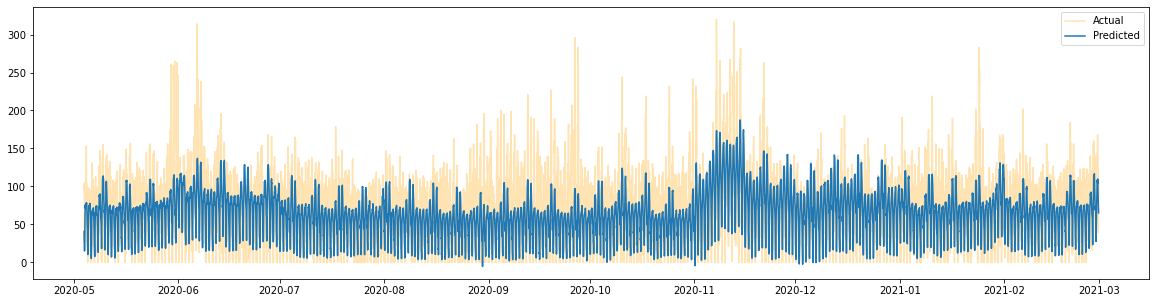

In [202]:
plt.figure(figsize=(20, 5))
plt.plot(y_test.index, y_test, label = "Actual",color='orange',alpha=0.3)
plt.plot(y_test.index, ypred2, label = "Predicted")
plt.legend();

In [ ]:
#using model to predict values for test

In [203]:
test.head()

,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


In [216]:
new_df3 = test

In [217]:
new_df3['timestamp'] = new_df3['date'] + " " +new_df3['hour'].astype('str') + ":00:00"

In [218]:
new_df3['timestamp'] = pd.to_datetime(new_df3['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [219]:
new_df3

,date,hour,timestamp
0,2021-03-01,0,2021-03-01 00:00:00
1,2021-03-01,1,2021-03-01 01:00:00
2,2021-03-01,2,2021-03-01 02:00:00
3,2021-03-01,3,2021-03-01 03:00:00
4,2021-03-01,5,2021-03-01 05:00:00
...,...,...,...
7645,2022-03-28,19,2022-03-28 19:00:00
7646,2022-03-28,20,2022-03-28 20:00:00
7647,2022-03-28,21,2022-03-28 21:00:00
7648,2022-03-28,22,2022-03-28 22:00:00


In [220]:
viz = new_df3

In [221]:
xgbdf = viz
xgbdf['hour'] = viz['timestamp'].dt.hour
xgbdf['dayofweek'] = viz['timestamp'].dt.dayofweek
xgbdf['quarter'] = viz['timestamp'].dt.quarter
xgbdf['month'] = viz['timestamp'].dt.month
xgbdf['year'] = viz['timestamp'].dt.year
xgbdf['dayofyear'] = viz['timestamp'].dt.dayofyear
xgbdf['sin_day'] = np.sin(xgbdf['dayofyear'])
xgbdf['cos_day'] = np.cos(xgbdf['dayofyear'])
xgbdf['dayofmonth'] = viz['timestamp'].dt.day
xgbdf['weekofyear'] = viz['timestamp'].dt.weekofyear

<ipython-input-221-7275fc0cb488>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  xgbdf['weekofyear'] = viz['timestamp'].dt.weekofyear


In [222]:
xgbdf

,date,hour,timestamp,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
0,2021-03-01,0,2021-03-01 00:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9
1,2021-03-01,1,2021-03-01 01:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9
2,2021-03-01,2,2021-03-01 02:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9
3,2021-03-01,3,2021-03-01 03:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9
4,2021-03-01,5,2021-03-01 05:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...
7645,2022-03-28,19,2022-03-28 19:00:00,0,1,3,2022,87,-0.821818,0.569750,28,13
7646,2022-03-28,20,2022-03-28 20:00:00,0,1,3,2022,87,-0.821818,0.569750,28,13
7647,2022-03-28,21,2022-03-28 21:00:00,0,1,3,2022,87,-0.821818,0.569750,28,13
7648,2022-03-28,22,2022-03-28 22:00:00,0,1,3,2022,87,-0.821818,0.569750,28,13


In [223]:
xgbdf = xgbdf.drop(['timestamp','sin_day','cos_day','dayofyear','weekofyear','quarter'], axis=1)

In [226]:
xgbdf = xgbdf.drop(['date'], axis=1)

In [227]:
xgbdf

,hour,dayofweek,month,year,dayofmonth
0,0,0,3,2021,1
1,1,0,3,2021,1
2,2,0,3,2021,1
3,3,0,3,2021,1
4,5,0,3,2021,1
...,...,...,...,...,...
7645,19,0,3,2022,28
7646,20,0,3,2022,28
7647,21,0,3,2022,28
7648,22,0,3,2022,28


In [228]:
xgbdf = xgbdf[["month", "hour", "dayofweek", "year", "dayofmonth"]]

In [229]:
y_final = grid.predict(xgbdf)

In [230]:
y_final

array([54.707558, 41.958984, 40.934036, ..., 78.04845 , 74.26527 ,
       67.313705], dtype=float32)

In [231]:
test['demand'] = y_final

In [232]:
test

,date,hour,timestamp,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear,demand
0,2021-03-01,0,2021-03-01 00:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9,54.707558
1,2021-03-01,1,2021-03-01 01:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9,41.958984
2,2021-03-01,2,2021-03-01 02:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9,40.934036
3,2021-03-01,3,2021-03-01 03:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9,29.646555
4,2021-03-01,5,2021-03-01 05:00:00,0,1,3,2021,60,-0.304811,-0.952413,1,9,36.606873
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,2022-03-28,19,2022-03-28 19:00:00,0,1,3,2022,87,-0.821818,0.569750,28,13,89.868958
7646,2022-03-28,20,2022-03-28 20:00:00,0,1,3,2022,87,-0.821818,0.569750,28,13,81.194878
7647,2022-03-28,21,2022-03-28 21:00:00,0,1,3,2022,87,-0.821818,0.569750,28,13,78.048447
7648,2022-03-28,22,2022-03-28 22:00:00,0,1,3,2022,87,-0.821818,0.569750,28,13,74.265266


In [236]:
test = test.drop(['timestamp','dayofweek','quarter','month', 'year', 'dayofyear', 'sin_day', 'cos_day', 'dayofmonth', 'weekofyear'], axis=1)

In [237]:
test.to_csv('pred_test.csv')